# Overfitting on the IMDB movie reviews dataset

In this notebook we shall focus on overfitting, demonstrating the phenomenon and studying techniques to address it. The dataset we shall use is the IMDB movie reviews dataset, composed of 25,000 movies reviews, labeled by sentiment (positive/negative).

To prevent overfitting, the best solution is to use more training data. When that is not a
viable possibility, you can try to use regularization techniques, constraining the quantity and quality of information stored by the model. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent ones, which have a better chance of generalizing well.



In [48]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import imdb
import matplotlib.pyplot as plt
import numpy as np

Let us load the dataset. In keras, the dataset is preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data.

In [49]:
num_words = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=num_words)

Let us a look at the encoding of the first review.

In [50]:
print(x_train[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


This representation has a variable length dimension, that is not very stuitable for a neural network.

Let us transform it into a multi_hot encoding of of dimension equal to num_words. In this representation, a word gets index 1 if it appears in the document. It is essentially a bag-of-words encoding.

In [51]:
def multi_hot_sequences(sequences, dimension):
  multi_hot = np.zeros((len(sequences),dimension))
  for i in range(0,len(sequences)):
    multi_hot[i, sequences[i]] = 1
  return multi_hot

x_train = multi_hot_sequences(x_train, num_words)
x_test = multi_hot_sequences(x_test, num_words)

Let us have a look at the initial part of the encoding for the first review.

In [52]:
print(x_train[0,0:30])

[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0.]


We now define our first model, that is just a concatenation of three dense layers.

In [53]:
seq = Input(shape=(num_words,))
x = Dense(64, activation='relu')(seq)
x = Dense(16, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

base_model = Model(seq, x)

In [54]:
base_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │          32,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,121 (129.38 KB)

 Trainable params: 33,121 (129.38 KB)

 Non-trainable params: 0 (0.00 B)

So, let's sum up what we did so far:


1.   We took the dataset of reviews of IMDB, to each of which is associated a positive/negative label.
2.   Each review is a sequence of words, and these words are mapped to integer indices, based on their frequency in the entire dataset. So, each review is represented as a sequence of numbers, where each number corresponds to a specific word in the vocabulary.
3.   We limit to the 500 most common words to simplify.
4.   Since the reviews have different lengths, we instead use a multi-hot encoding. Therefore, the input to the neural network will always be a 500 element vector where each element is 1 if that word of the vocabulary is present in that review, 0 otherwise.
5.   We created the neural network ending with a sigmoid, which will give us a value between 0 and 1, representing the probability that the review in input is positive.



We compile the model using adam as optimizer, and binary crossentropy (log likelyhood) as loss function. The fit function returns a history of the training, that can be later inspected. In addition to the loss function, that is the canonical metric used for training, we also ask the model to keep trace of accuracy.

In [55]:
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
base_history = base_model.fit(
    x_train,
    y_train,
    epochs = 6,
    batch_size = 512,
    validation_data = (x_test, y_test),
    verbose = 1
)

Epoch 1/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6296 - loss: 0.6515 - val_accuracy: 0.8010 - val_loss: 0.4431
Epoch 2/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8193 - loss: 0.4099 - val_accuracy: 0.8284 - val_loss: 0.3894
Epoch 3/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8405 - loss: 0.3701 - val_accuracy: 0.8314 - val_loss: 0.3838
Epoch 4/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8389 - loss: 0.3617 - val_accuracy: 0.8343 - val_loss: 0.3801
Epoch 5/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8483 - loss: 0.3506 - val_accuracy: 0.8340 - val_loss: 0.3788
Epoch 6/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8516 - loss: 0.3440 - val_accuracy: 0.8306 - val_loss: 0.3824


Let us see the keys available in our history.

In [57]:
print(base_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


The following function allows us to plot the results.

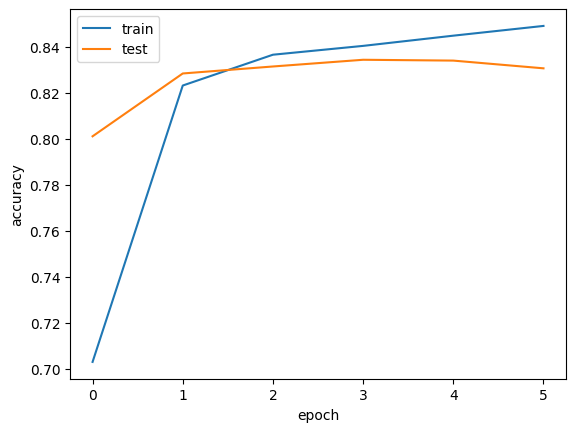

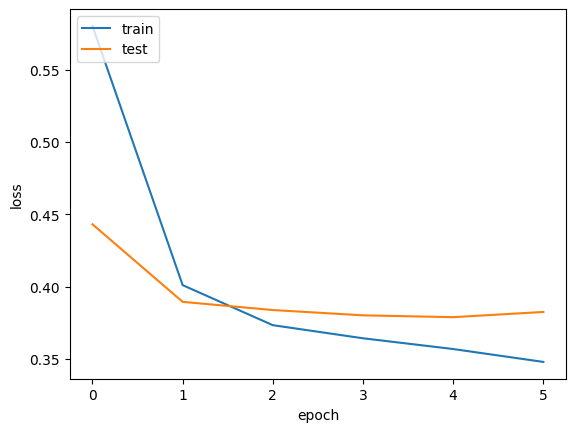

In [58]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(base_history,['accuracy','val_accuracy'])
plot_history(base_history,['loss','val_loss'])


The loss for the training set decreases smoothly as we advance with the epochs.
On the other hand, for the test set, the loss initially decreases a bit, but then it remains fixed.

We can see the same thing for the accuracy. After the first epoch, we don't improve anymore.

This is **overfitting**.

# Weight regularization

Now we modify our base model adding regularizers.

To combat overfitting, we want to reduce the complexity of the model or restrict its ability to memorize the data. One effective way to do this is weight regularization, which **penalizes large weights** in the model. The goal is to keep the model's weights small, preventing it from becoming overly complex and fitting noise in the training data.

L_reg = L_original + λ*∑w<sub>i</sub><sup>2</sup>.

If any weight w_i becomes very large, the penalty term increases significantly.
The optimizer (e.g., Adam) will try to minimize the total loss, which includes this penalty.
To minimize the loss, the optimizer will prefer smaller weight values. Easy isn't?

In [59]:
from keras import regularizers

seq = Input(shape=(num_words,))
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005))(seq)
x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.005))(x)
x = Dense(1, activation='sigmoid')(x)

l2reg_model = Model(seq, x)

In [60]:
l2reg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
l2reg_history = l2reg_model.fit(
    x_train,
    y_train,
    epochs = 5,
    batch_size = 512,
    validation_data = (x_test, y_test),
    verbose = 2
)

Epoch 1/5
49/49 - 2s - 48ms/step - accuracy: 0.6741 - loss: 1.0950 - val_accuracy: 0.7897 - val_loss: 0.7963
Epoch 2/5
49/49 - 1s - 16ms/step - accuracy: 0.8188 - loss: 0.6592 - val_accuracy: 0.8277 - val_loss: 0.5755
Epoch 3/5
49/49 - 1s - 13ms/step - accuracy: 0.8307 - loss: 0.5337 - val_accuracy: 0.8295 - val_loss: 0.5105
Epoch 4/5
49/49 - 1s - 18ms/step - accuracy: 0.8338 - loss: 0.4879 - val_accuracy: 0.8309 - val_loss: 0.4812
Epoch 5/5
49/49 - 1s - 27ms/step - accuracy: 0.8334 - loss: 0.4650 - val_accuracy: 0.8329 - val_loss: 0.4615


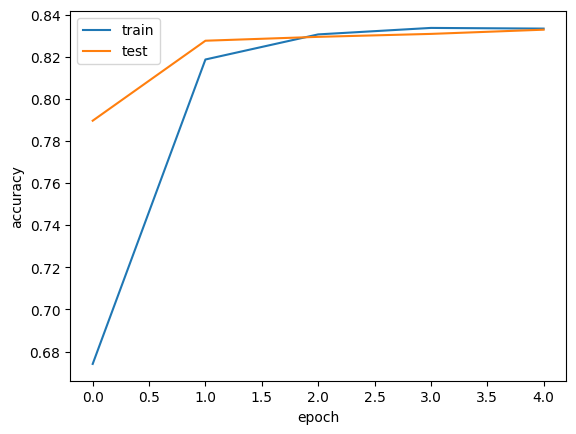

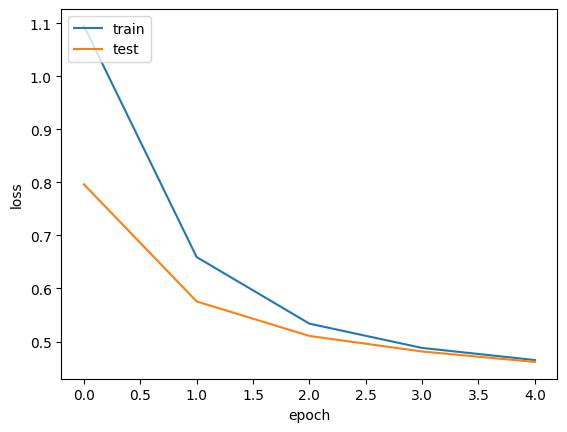

In [62]:
plot_history(l2reg_history,['accuracy','val_accuracy'])
plot_history(l2reg_history,['loss','val_loss'])

# Dropout

Dropout is an alternative regularization techniques for neural networks.

It consists of randomly “dropping out” (i.e. set to zero) during training a number of output features of the layer during training. This forces the network to **not depend too much on any single neuron**, preventing overfitting.


During testing, Dropout is not applied, meaning that all neurons are active. However, their outputs are scaled down by the dropout rate.
For example, if 50% dropout was used during training, at test time the output values are multiplied by 0.5 to compensate for the fact that more neurons are now active.

In [63]:
from keras.layers import Dropout
from keras import optimizers

Let’s add a couple of dropout layers in our IMDB network and see how it performs.


In [64]:
seq = Input(shape=(num_words,))
x = Dense(64, activation='relu')(seq)
x = Dropout(0.5)(x) #drop 50% of neurons
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)  #drop 50% of neurons
x = Dense(1, activation='sigmoid')(x)

dropout_model = Model(seq, x)

In [65]:
dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
dropout_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │          32,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,121 (129.38 KB)

 Trainable params: 33,121 (129.38 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
dropout_history = dropout_model.fit(
    x_train,
    y_train,
    epochs = 5,
    batch_size = 512,
    validation_data = (x_test, y_test),
    verbose = 1
)

Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5313 - loss: 0.7134 - val_accuracy: 0.7337 - val_loss: 0.6214
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6665 - loss: 0.6110 - val_accuracy: 0.8004 - val_loss: 0.4719
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7573 - loss: 0.5083 - val_accuracy: 0.8182 - val_loss: 0.4178
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7931 - loss: 0.4602 - val_accuracy: 0.8216 - val_loss: 0.3961
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8093 - loss: 0.4352 - val_accuracy: 0.8266 - val_loss: 0.3828


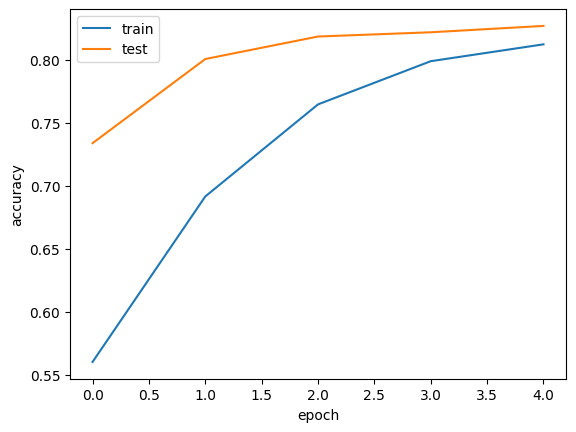

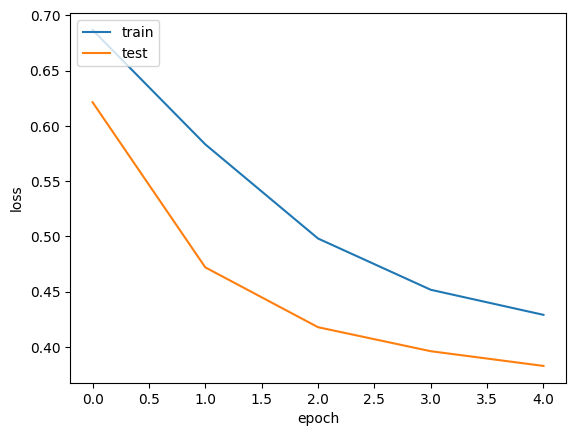

In [68]:
plot_history(dropout_history,['accuracy','val_accuracy'])
plot_history(dropout_history,['loss','val_loss'])

We now try to combine l2 regulirizer and dropout. We use both, for each layer.

In [69]:
seq = Input(shape=(num_words,))
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005))(seq)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

mixed_model = Model(seq, x)

In [71]:
adam = optimizers.Adam(learning_rate=0.001)  # Use learning_rate instead of lr
mixed_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


In [72]:
mixed_history = mixed_model.fit(
    x_train,
    y_train,
    epochs = 5,
    batch_size = 512,
    validation_data = (x_test, y_test),
    verbose = 2
)

Epoch 1/5
49/49 - 3s - 58ms/step - accuracy: 0.5382 - loss: 1.2172 - val_accuracy: 0.6953 - val_loss: 1.0120
Epoch 2/5
49/49 - 1s - 17ms/step - accuracy: 0.6788 - loss: 0.8657 - val_accuracy: 0.8008 - val_loss: 0.6871
Epoch 3/5
49/49 - 1s - 24ms/step - accuracy: 0.7808 - loss: 0.6561 - val_accuracy: 0.8248 - val_loss: 0.5567
Epoch 4/5
49/49 - 1s - 14ms/step - accuracy: 0.8108 - loss: 0.5736 - val_accuracy: 0.8284 - val_loss: 0.5103
Epoch 5/5
49/49 - 1s - 25ms/step - accuracy: 0.8209 - loss: 0.5295 - val_accuracy: 0.8300 - val_loss: 0.4839


# Early stopping

Early stopping is a technique used to prevent overfitting and reduce training time by stopping the training process once the model performance stops improving on the validation set.

**During training, the model's performance is monitored on both the training set and the validation set.**

*   If the validation loss keeps decreasing, training continues.
*   If the validation loss stops improving for a given number of epochs (patience), training is stopped early to prevent overfitting.

This means that the model stops training before it starts memorizing noise from the training data.

This requires that a validation set must be provided to the fit() function.

Early stopping can be simply implemented in keras using callbacks.
A callback is a function taht is called at specific stages of the training procedure: start/end of epochs, start end of minibatches, etc.

You can use callbacks to get a view on internal states and statistics of the model during training. A list of callbacks can be passed to the .fit() function using the keyword argument "callbacks".

In [78]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

#WE CREATE THE TWO CALLBACKS THAT WE WILL USE IN .fit

saveDir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

#mixed_model.load_weights(saveDir + 'Cifar10_to256.keras') #uncomment to load the weights that we saved in a previous execution thanks to the ModelCheckpoint callback (see explanation below)

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
#monitor='val_loss' → Watches the validation loss during training.
#patience=3 If the validation loss does not improve for 3 consecutive epochs, training stops.
#mode='auto' → Automatically determines whether to minimize (for loss) or maximize (for accuracy).

chkpt = saveDir + 'Cifar10_to256.keras'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#Saves the best model (with the lowest validation loss) during training.
#save_best_only=True → Only saves the model if it achieves a new best validation loss.

In [76]:
mixed_model.fit(x_train, y_train,
                batch_size=512, #batch_size,
                epochs= 20,
                verbose=1,
                validation_data=(x_test,y_test),
                callbacks=[es_cb, cp_cb], #we pass a list of callbacks that we created earlier.
                shuffle=True)

Epoch 1/20
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8215 - loss: 0.5112
Epoch 1: val_loss improved from inf to 0.47021, saving model to /content/saved_modelsCifar10_to256.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8216 - loss: 0.5112 - val_accuracy: 0.8313 - val_loss: 0.4702
Epoch 2/20
41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8218 - loss: 0.4954
Epoch 2: val_loss improved from 0.47021 to 0.46078, saving model to /content/saved_modelsCifar10_to256.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8222 - loss: 0.4947 - val_accuracy: 0.8301 - val_loss: 0.4608
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8269 - loss: 0.4795
Epoch 3: val_loss improved from 0.46078 to 0.45101, saving model to /content/saved_modelsCifar10_to256.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8269 - loss: 0.4795 - val_accuracy: 0.8314 - val_loss: 0.4510
Epoch 4/20
40/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8358 - loss: 

In [77]:
loss,acc = mixed_model.evaluate(x_test,y_test)
print("test loss = ", loss)
print("test accuracy = ", acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8342 - loss: 0.4299
test loss =  0.4287998080253601
test accuracy =  0.8334800004959106


Why use checkpoint?

If you only use EarlyStopping, the training stops as soon as the validation loss stops improving for the set patience epochs.

What's the issue?The last trained model is kept, but it may not be the best model.
The best model might have been at an earlier epoch before training stopped.

When Should You Use load_weights?
- Before training (to continue training from the best model instead of restarting from random weights).
- After training (to ensure you use the best model, not the last trained one).